# May 17th, 2022 (ca bp, lombscargle_fill, finalize)

**Motivation**: lombscargle fill is absolutely and utterly unnecessary for Ca data. Decided to skip it from inside reg._organize_func() <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
_fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = 'Documents/workspaces/lfr/binary_overlapping'
lfr_dir = pjoin(os.environ['HOME'], lfr_dir)

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# RABIES
sys.path.insert(0, pjoin(git_dir, 'RABIES'))
from rabies.confound_correction_pkg.utils import butterworth as rb_butter

# set style
%matplotlib inline
set_style()

# warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def show_timeseries(segments, x, y, yf, intvl, ylim=None, figsize=(13.5, 7), grid=True, title=None, show=True):
    min_val, max_val = intvl
    fig, axes = create_figure(3, 1, figsize, 'all', 'all')
    for ax in axes.flat:
        for seg in segments:
            ax.axvspan(min(seg), max(seg), color='dimgrey', alpha=0.3, lw=0,  zorder=0)

    axes[0].plot(x.mean(0).squeeze()[500:], label='actual')
    axes[1].plot(y.mean(0), label='filled')
    for b, _y in yf.items():
        axes[2].plot(_y.mean(0), label=f'filled-bp{b}'.replace(' ', ''))
    axes[2].set_xlim(min_val, max_val)
    for ax in axes.flat:
        ax.legend(loc='upper right')
    if ylim is not None:
        axes[-1].set_ylim(*ylim)
    if grid:
        add_grid(axes)
    sup = fig.suptitle(title if title else key, fontsize=17, y=1.01)
    if show:
        plt.show()
    else:
        plt.close()
    return fig, sup


def show_spectogram(spect_dict, xlim, figsize=(9, 11), title=None, show: bool = True):
    fig, axes = create_figure(len(spect_dict), 2, figsize, 'col', 'row', width_ratios=[1, 0.4])
    kws = {
        'vmin': min(v[-1].mean(0).min() for v in spect_dict.values()),
        'vmax': max(v[-1].mean(0).max() for v in spect_dict.values()),
        'cmap': 'Spectral_r',
        'shading': 'gouraud',
        'norm': matplotlib.colors.LogNorm()
    }
    for i, (lbl, (_f, _t, _sxx)) in enumerate(spect_dict.items()):
        _sxx = _sxx.mean(0)
        im = axes[i, 0].pcolormesh(_t, _f, _sxx, **kws)
        plt.colorbar(im, ax=axes[i, 0])

        axes[i, 1].plot(_sxx.mean(1), _f, label=lbl)
        axes[i, 1].tick_params(
            axis='y',
            which='both',
            left=True,
            right=True,
            labelleft=False,
            labelright=True,
        )
        if i == 2:
            axes[i, 0].set_xlabel('Time [s]')
            axes[i, 1].set_xlabel('Power')
        axes[i, 0].set_ylabel('Frequency [Hz]')
        axes[i, 1].set_ylabel('Frequency [Hz]', rotation=-90, labelpad=20)
        axes[i, 1].yaxis.set_label_position('right')
        axes[i, 1].legend(loc='upper right')
        axes[i, 1].set_xscale('log')
        axes[i, 1].grid()
    axes[-1, -1].set_xlim(*xlim)
    sup = fig.suptitle(title if title else key, fontsize=17, y=1.01)
    if show:
        plt.show()
    else:
        plt.close()
    return fig, sup

In [3]:
from register.register import Register
from register.preprocess import process_ca, contig_segments

In [4]:
save_dir = pjoin(_fig_dir, 'quality_control', 'CA2_lombscargle')
os.makedirs(save_dir, exist_ok=True)
save_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/quality_control/CA2_lombscargle'

## Loop over runs

In [5]:
mice = Mice(192, full_load=True, load_allen=True, load_parcel=True)

reg = Register(mice)
tsnr_masks = reg.get_tsnr_masks(q_bold=0.1)

Name: cortex . . . a total of: 224 regions accepted, 160 regions rejected.
accept ratio: 58.33 %, reject ratio: 41.67 %, using a presence threshold of 20.0 %

In [6]:
%%time

nperseg = 512
kws_fill = {
    'b': (0.005, 10),
    'logspace': False,
    'nf': None,
    'dt': 1/10,
}
for key, func in tqdm(mice.ca_preproc.items()):
    _k = mice.get_key(*mice.looper[key][:2])
    if func.nii_file is None:
        continue
    x = func.load_ants().numpy().astype(float)
    m_indiv = mice.mask2d[_k].load_ants()
    m_indiv = m_indiv.numpy().astype(bool)
    m_tsnr = tsnr_masks['ca2'].get(key)
    if m_tsnr is not None:
        m_indiv = np.logical_and(m_indiv, m_tsnr)
    
    figs, sups = [], []
    for nf in [1000, 2000, 3000]:
        kws_fill['nf'] = nf
        title = f"{key}  . . .  NUM Freq = {nf}"
        
        y, yf, tmask = process_ca(mice, key, x, m_indiv, kws_fill=kws_fill, band=[0.5, (0.01, 0.5)])
        segments = contig_segments(tmask)
        
        f1, s1 = show_timeseries(
            segments, x[m_indiv], y, yf, (2000, 3000), figsize=(9, 9), title=title, show=False)
        figs.append(f1)
        sups.append(s1)
        
        spect_dict = {
            f"bp{b}".replace(' ', ''): sp_sig.spectrogram(_y, 10, nperseg=nperseg)
            for b, _y in yf.items()
        }
        spect_dict = {
            'full': sp_sig.spectrogram(
                x[m_indiv].squeeze()[:, x.shape[-1] - len(tmask):], 10, nperseg=nperseg),
            'filled': sp_sig.spectrogram(y, 10, nperseg=nperseg),
            **spect_dict
        }
        f2, s2 = show_spectogram(spect_dict, (1e2, 2e4), title=title, show=False)
        figs.append(f2)
        sups.append(s2)
        
    save_fig(figs, sups, pjoin(save_dir, f"lombsc_{key}.pdf"), multi=True)

  0%|          | 0/210 [00:00<?, ?it/s]

CPU times: user 1d 3h 47min 26s, sys: 5h 9min 43s, total: 1d 8h 57min 10s
Wall time: 11h 15min 52s


## Check different fill settings

In [3]:
mice = Mice(192, full_load=True, load_allen=True, load_parcel=True)

In [4]:
_k = 'sub-SLC06_ses-3'
key = 'sub-SLC06_ses-3_run-3'
m = mice.mask3d[_k].load_ants().numpy().astype(bool)
func = mice.ca_preproc[key]
x = func.load_ants().numpy().astype(float)
x.shape

(256, 250, 1, 6000)

In [5]:
from register.register import Register

reg = Register(mice)
tsnr_masks = reg.get_tsnr_masks(q_bold=0.1)

Name: cortex . . . a total of: 224 regions accepted, 160 regions rejected.
accept ratio: 58.33 %, reject ratio: 41.67 %, using a presence threshold of 20.0 %

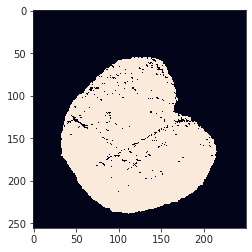

In [6]:
m_indiv = mice.mask2d[_k].load_ants()
m_indiv = m_indiv.numpy().astype(bool)
m_tsnr = tsnr_masks['ca2'].get(key)
if m_tsnr is not None:
    m_indiv = np.logical_and(m_indiv, m_tsnr)
plt.imshow(m_indiv);

### First try linspace with Num = 1000

In [8]:
kws_fill = {
    'b': (0.005, 10),
    'logspace': False,
    'nf': 1000,
    'dt': 1 / 10,
}
y, yf, tmask = process_ca(mice, key, x, m_indiv, kws_fill=kws_fill, band=[0.5, (0.01, 0.5)])
segments = contig_segments(tmask)

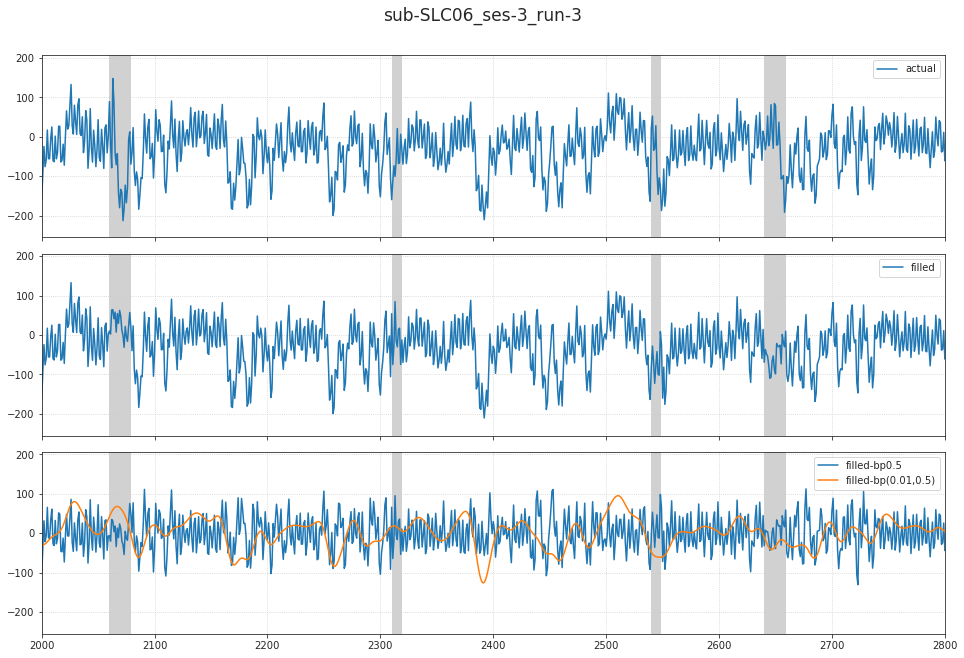

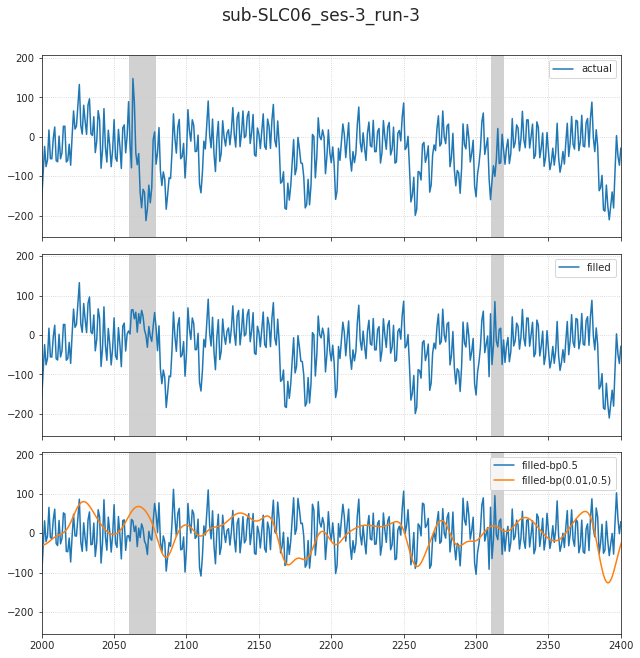

In [9]:
_ = show_timeseries(segments, x[m_indiv], y, yf, (2000, 2800), figsize=(13.5, 9))
_ = show_timeseries(segments, x[m_indiv], y, yf, (2000, 2400), figsize=(9, 9))

In [10]:
nperseg = 512
spect_dict = {
    f"bp{b}".replace(' ', ''): sp_sig.spectrogram(_y, 10, nperseg=nperseg)
    for b, _y in yf.items()
}
spect_dict = {
    'full': sp_sig.spectrogram(x[m_indiv].squeeze()[:, x.shape[-1] - len(tmask):], 10, nperseg=nperseg),
    'filled': sp_sig.spectrogram(y, 10, nperseg=nperseg),
    **spect_dict
}

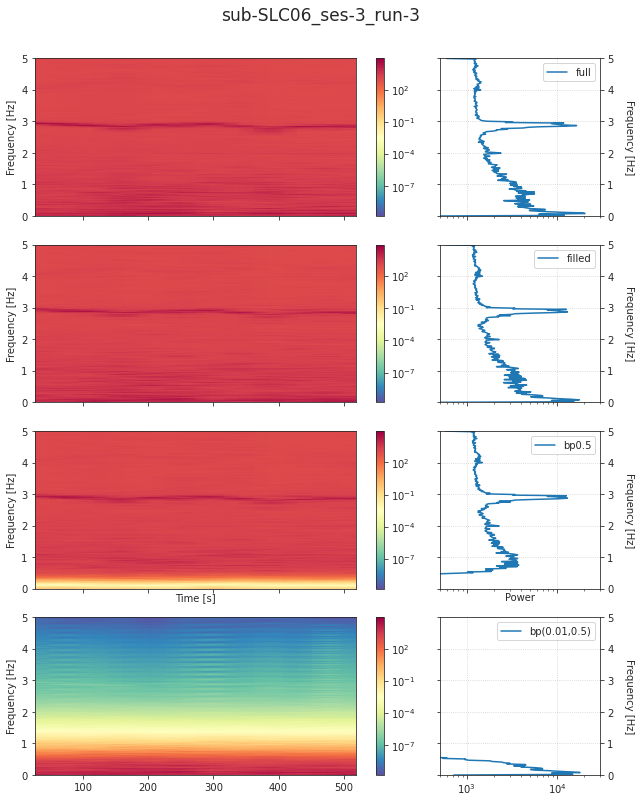

In [11]:
_ = show_spectogram(spect_dict, (5e2, 3e4))

### What about log space Num = 1000?

In [12]:
kws_fill = {
    'b': (0.005, 10),
    'logspace': True,
    'nf': 1000,
    'dt': 1 / 10,
}
y, yf, tmask = process_ca(mice, key, x, m_indiv, kws_fill=kws_fill, band=[0.5, (0.01, 0.5)])
segments = contig_segments(tmask)

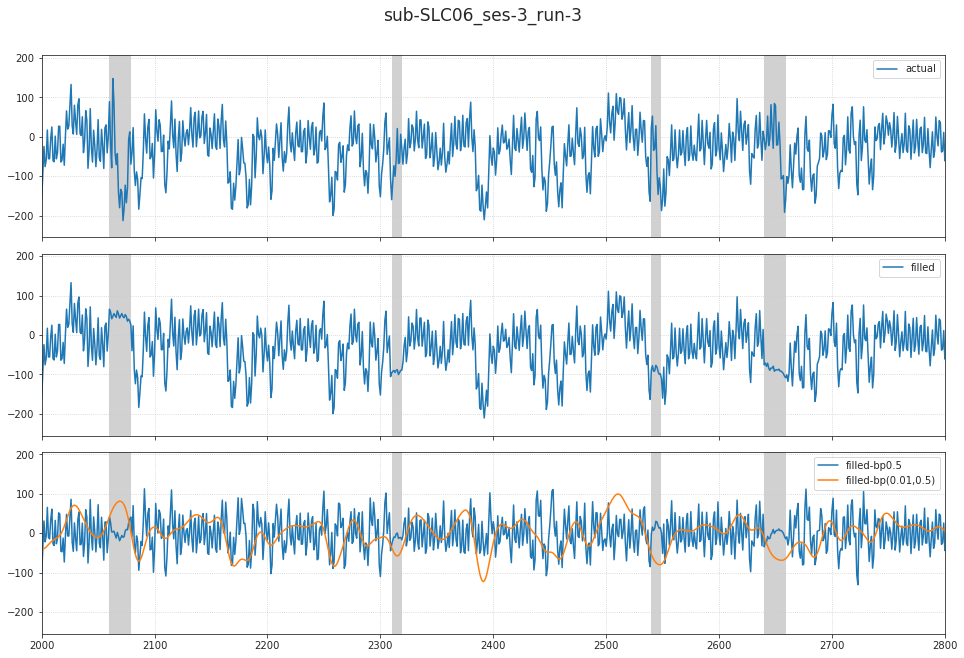

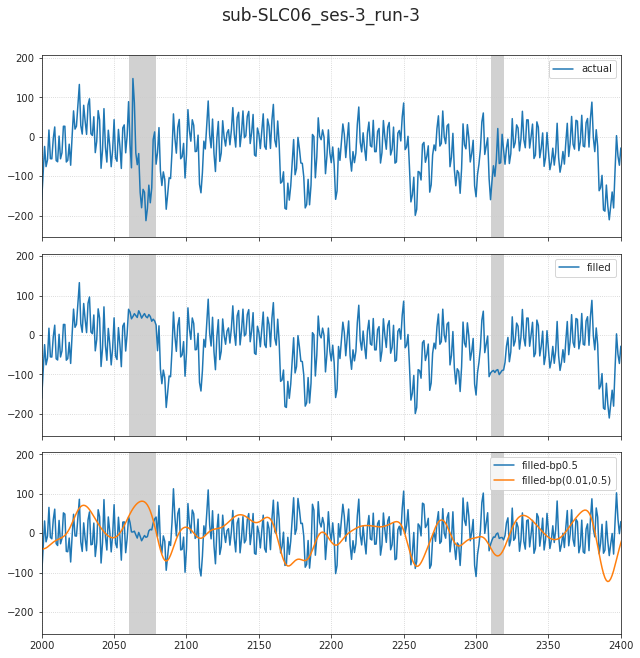

In [13]:
_ = show_timeseries(segments, x[m_indiv], y, yf, (2000, 2800), figsize=(13.5, 9))
_ = show_timeseries(segments, x[m_indiv], y, yf, (2000, 2400), figsize=(9, 9))

In [14]:
nperseg = 512
spect_dict = {
    f"bp{b}".replace(' ', ''): sp_sig.spectrogram(_y, 10, nperseg=nperseg)
    for b, _y in yf.items()
}
spect_dict = {
    'full': sp_sig.spectrogram(x[m_indiv].squeeze()[:, x.shape[-1] - len(tmask):], 10, nperseg=nperseg),
    'filled': sp_sig.spectrogram(y, 10, nperseg=nperseg),
    **spect_dict
}

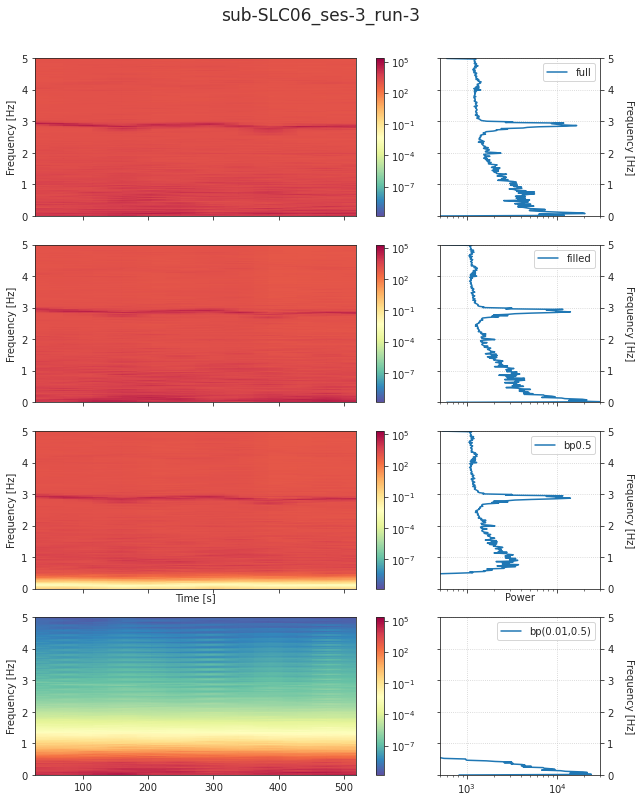

In [15]:
_ = show_spectogram(spect_dict, (5e2, 3e4))

### Now provide custom frequencies

[<matplotlib.lines.Line2D object at 0x7fcaf137c250>]

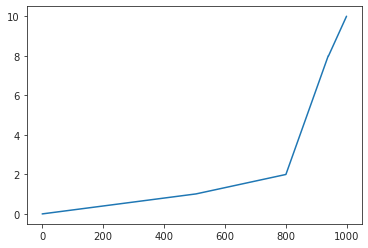

In [16]:
freqs = np.concatenate([
    np.linspace(0.005, 1, 500),
    np.linspace(1, 2, 300),
    np.linspace(2, 8, 140),
    np.linspace(8, 10, 60),
])
plt.plot(freqs)

In [17]:
kws_fill = {
    'freqs': freqs,
    'dt': 1 / 10,
}
y, yf, tmask = process_ca(mice, key, x, m_indiv, kws_fill=kws_fill, band=[0.5, (0.01, 0.5)])
segments = contig_segments(tmask)

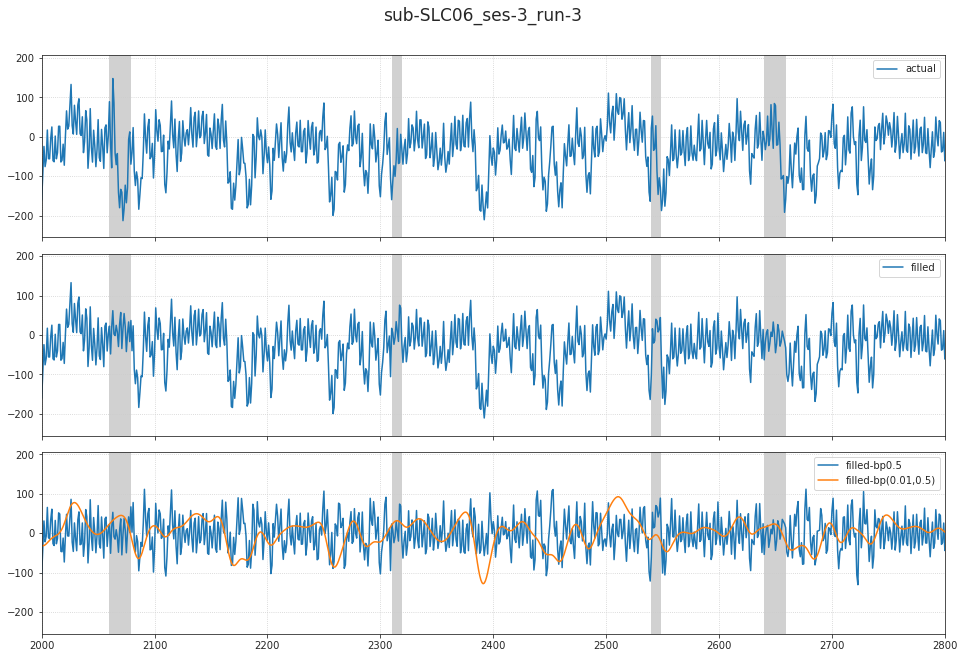

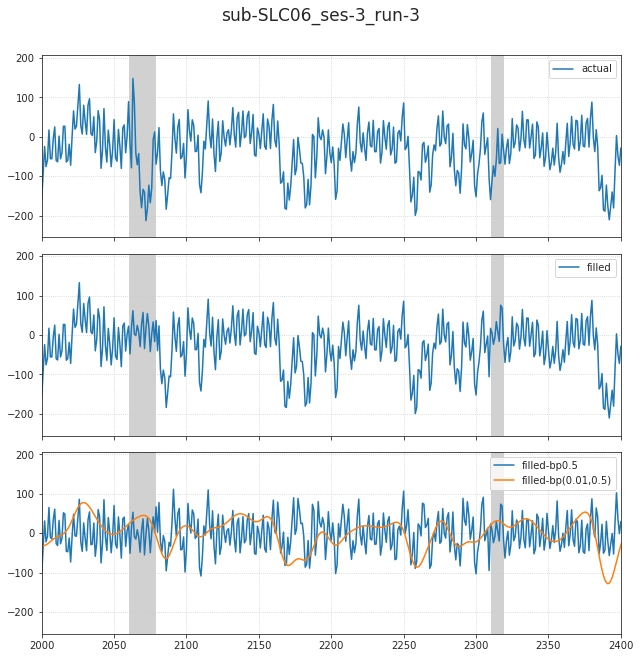

In [18]:
_ = show_timeseries(segments, x[m_indiv], y, yf, (2000, 2800), figsize=(13.5, 9))
_ = show_timeseries(segments, x[m_indiv], y, yf, (2000, 2400), figsize=(9, 9))

In [19]:
nperseg = 512
spect_dict = {
    f"bp{b}".replace(' ', ''): sp_sig.spectrogram(_y, 10, nperseg=nperseg)
    for b, _y in yf.items()
}
spect_dict = {
    'full': sp_sig.spectrogram(x[m_indiv].squeeze()[:, x.shape[-1] - len(tmask):], 10, nperseg=nperseg),
    'filled': sp_sig.spectrogram(y, 10, nperseg=nperseg),
    **spect_dict
}

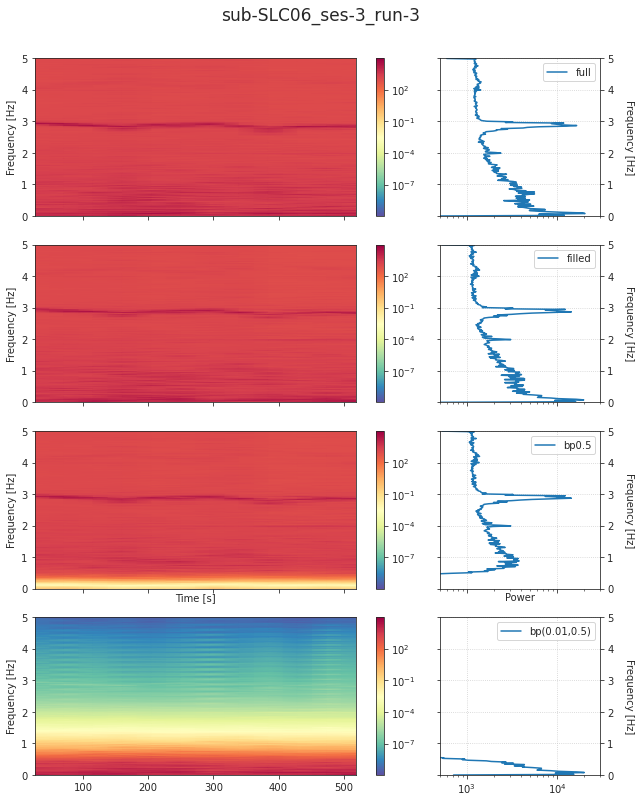

In [20]:
_ = show_spectogram(spect_dict, (5e2, 3e4))

### Finally, linspace with Num = 2000

In [21]:
kws_fill = {
    'b': (0.005, 10),
    'logspace': False,
    'nf': 2000,
    'dt': 1 / 10,
}
y, yf, tmask = process_ca(mice, key, x, m_indiv, kws_fill=kws_fill, band=[0.5, (0.01, 0.5)])
segments = contig_segments(tmask)

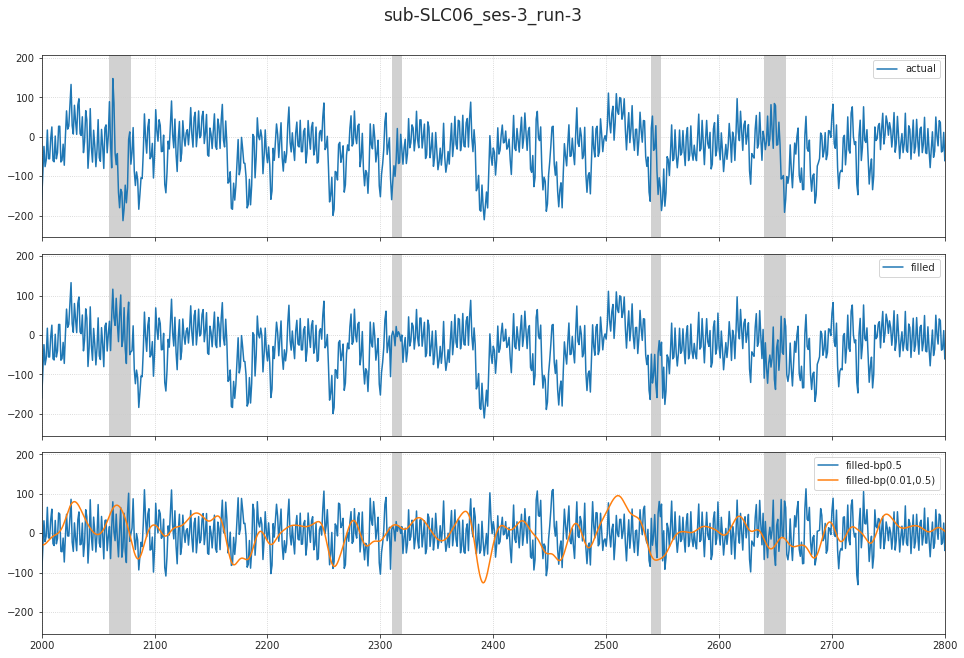

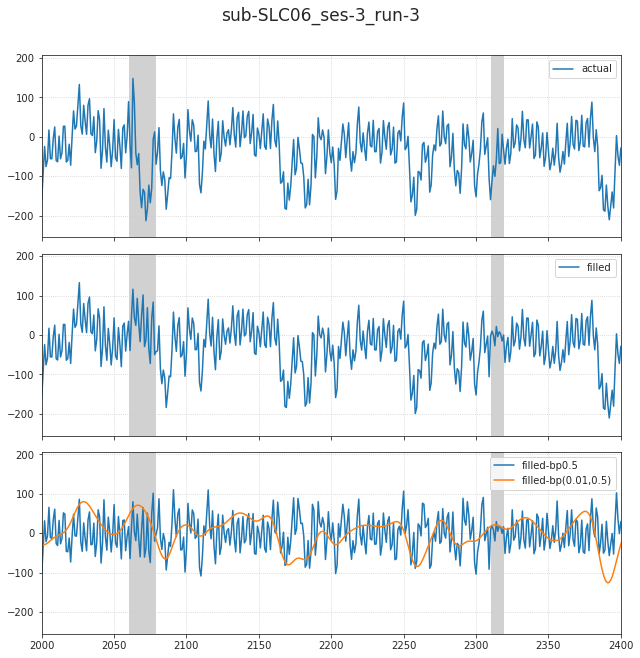

In [22]:
_ = show_timeseries(segments, x[m_indiv], y, yf, (2000, 2800), figsize=(13.5, 9))
_ = show_timeseries(segments, x[m_indiv], y, yf, (2000, 2400), figsize=(9, 9))

In [23]:
nperseg = 512
spect_dict = {
    f"bp{b}".replace(' ', ''): sp_sig.spectrogram(_y, 10, nperseg=nperseg)
    for b, _y in yf.items()
}
spect_dict = {
    'full': sp_sig.spectrogram(x[m_indiv].squeeze()[:, x.shape[-1] - len(tmask):], 10, nperseg=nperseg),
    'filled': sp_sig.spectrogram(y, 10, nperseg=nperseg),
    **spect_dict
}

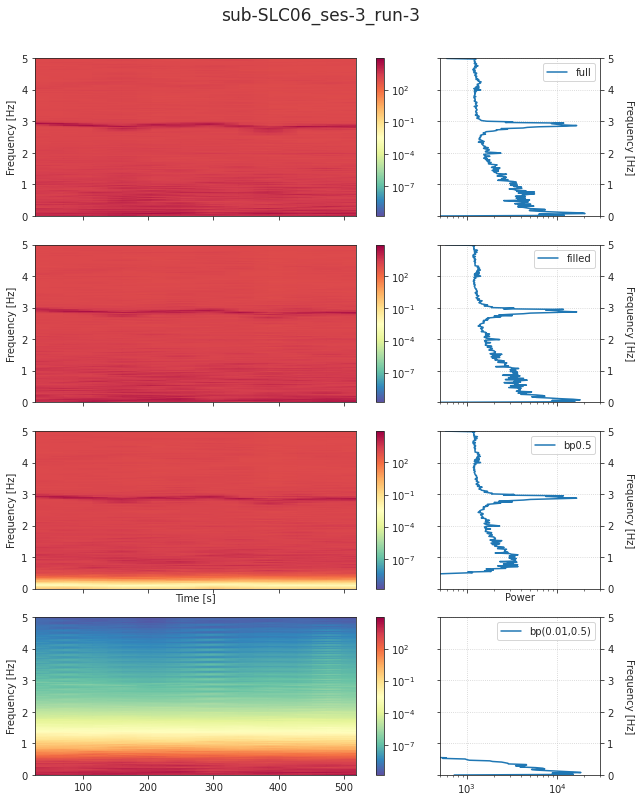

In [24]:
_ = show_spectogram(spect_dict, (5e2, 3e4))

## Another run

In [31]:
_k = 'sub-SLC07_ses-1'
key = 'sub-SLC07_ses-1_run-7'
m = mice.mask3d[_k].load_ants().numpy().astype(bool)
func = mice.ca_preproc[key]

x = func.load_ants().numpy().astype(float)
x.shape

(256, 250, 1, 6000)

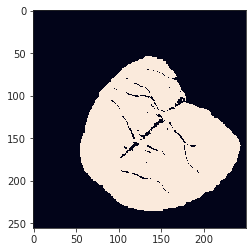

In [32]:
m_indiv = mice.mask2d[_k].load_ants()
m_indiv = m_indiv.numpy().astype(bool)
m_tsnr = tsnr_masks['ca2'].get(key)
if m_tsnr is not None:
    m_indiv = np.logical_and(m_indiv, m_tsnr)
plt.imshow(m_indiv);

### First try linspace with Num = 1000

In [33]:
kws_fill = {
    'b': (0.005, 10),
    'logspace': False,
    'nf': 1000,
    'dt': 1 / 10,
}
y, yf, tmask = process_ca(mice, key, x, m_indiv, kws_fill=kws_fill, band=[0.5, (0.01, 0.5)])
segments = contig_segments(tmask)

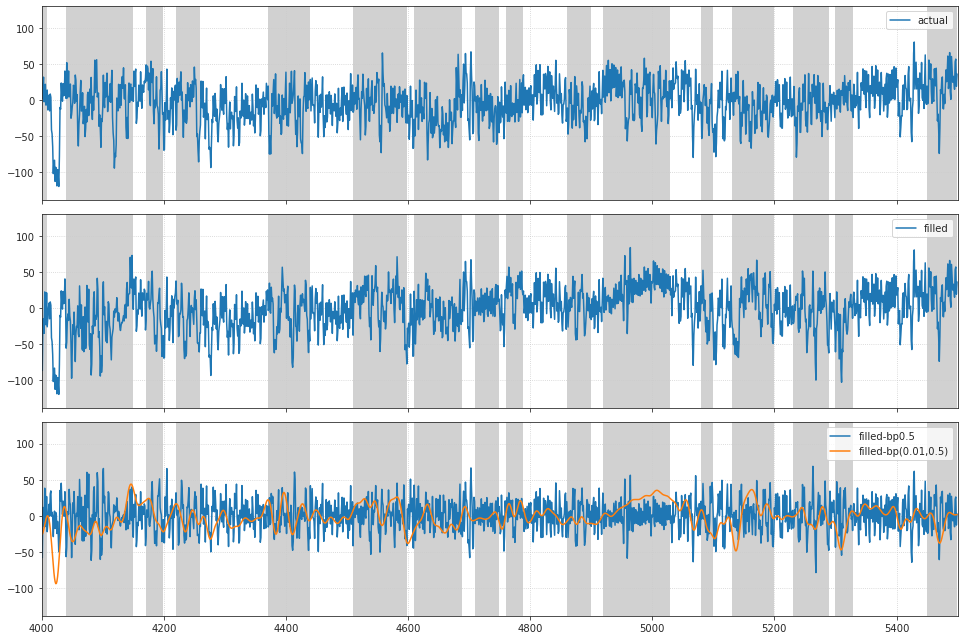

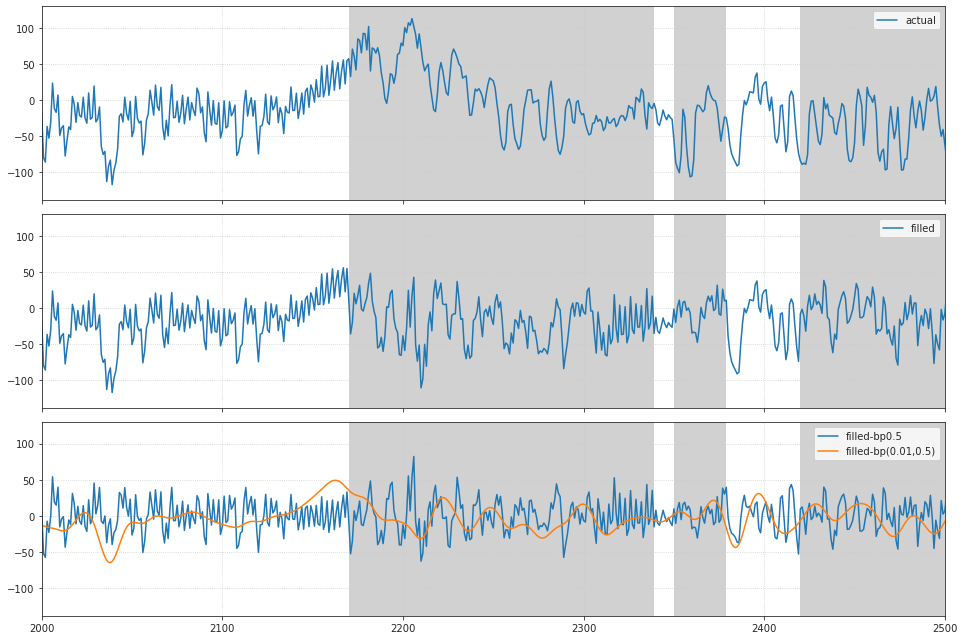

In [36]:
show_timeseries(segments, x[m_indiv], y, yf, (4000, 5500), figsize=(13.5, 9))
show_timeseries(segments, x[m_indiv], y, yf, (2000, 2500), figsize=(13.5, 9))

In [37]:
nperseg = 512
spect_dict = {
    f"bp{b}".replace(' ', ''): sp_sig.spectrogram(_y, 10, nperseg=nperseg)
    for b, _y in yf.items()
}
spect_dict = {
    'full': sp_sig.spectrogram(x[m_indiv].squeeze()[:, x.shape[-1] - len(tmask):], 10, nperseg=nperseg),
    'filled': sp_sig.spectrogram(y, 10, nperseg=nperseg),
    **spect_dict
}

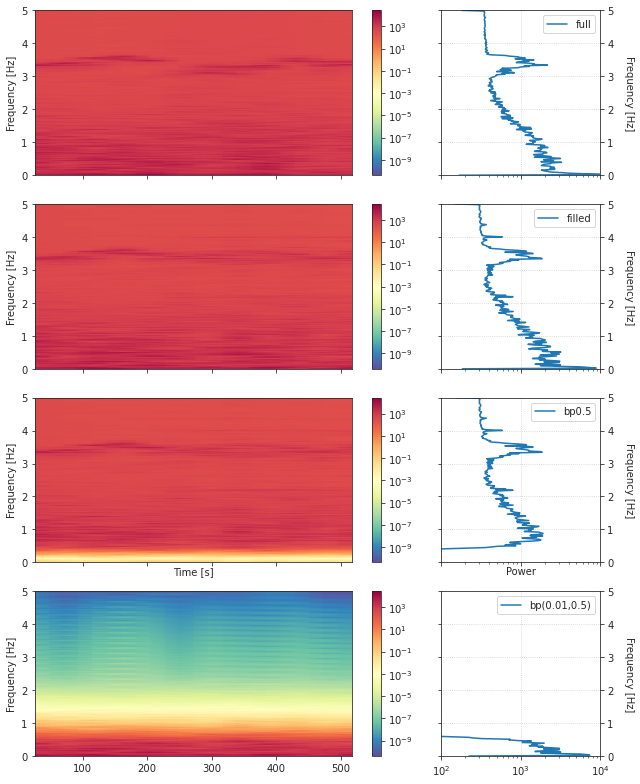

In [40]:
show_spectogram(spect_dict, (1e2, 1e4))

### What about log space Num = 1000?

In [41]:
kws_fill = {
    'b': (0.005, 10),
    'logspace': True,
    'nf': 1000,
    'dt': 1 / 10,
}
y, yf, tmask = process_ca(mice, key, x, m_indiv, kws_fill=kws_fill, band=[0.5, (0.01, 0.5)])
segments = contig_segments(tmask)

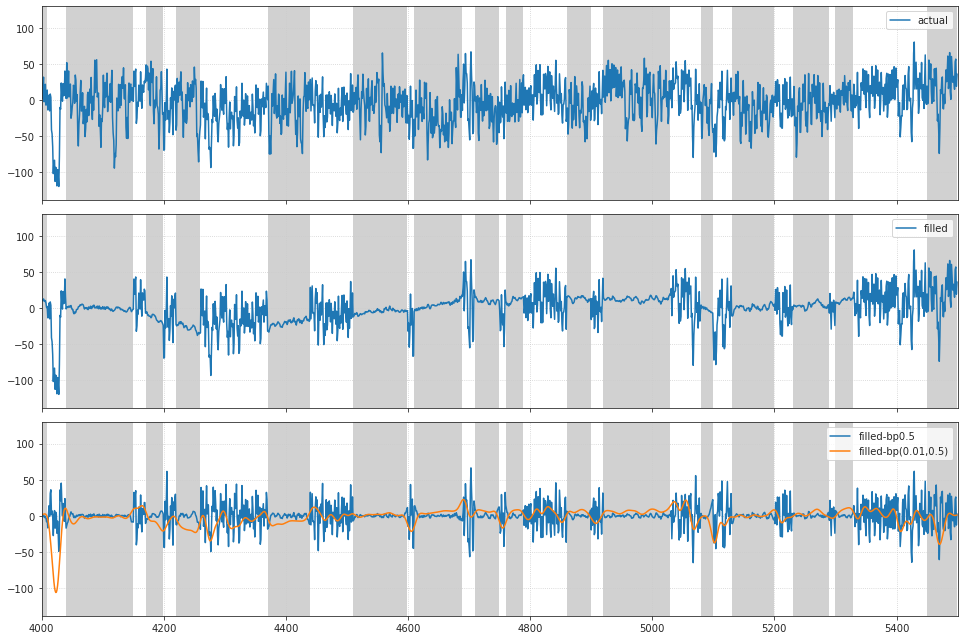

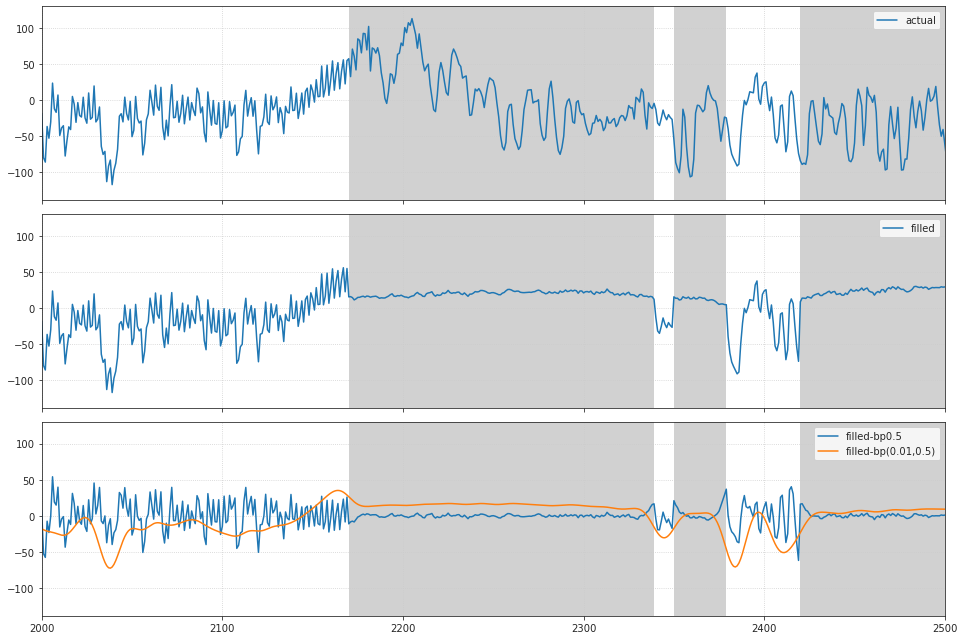

In [42]:
show_timeseries(segments, x[m_indiv], y, yf, (4000, 5500), figsize=(13.5, 9))
show_timeseries(segments, x[m_indiv], y, yf, (2000, 2500), figsize=(13.5, 9))

In [43]:
nperseg = 512
spect_dict = {
    f"bp{b}".replace(' ', ''): sp_sig.spectrogram(_y, 10, nperseg=nperseg)
    for b, _y in yf.items()
}
spect_dict = {
    'full': sp_sig.spectrogram(x[m_indiv].squeeze()[:, x.shape[-1] - len(tmask):], 10, nperseg=nperseg),
    'filled': sp_sig.spectrogram(y, 10, nperseg=nperseg),
    **spect_dict
}

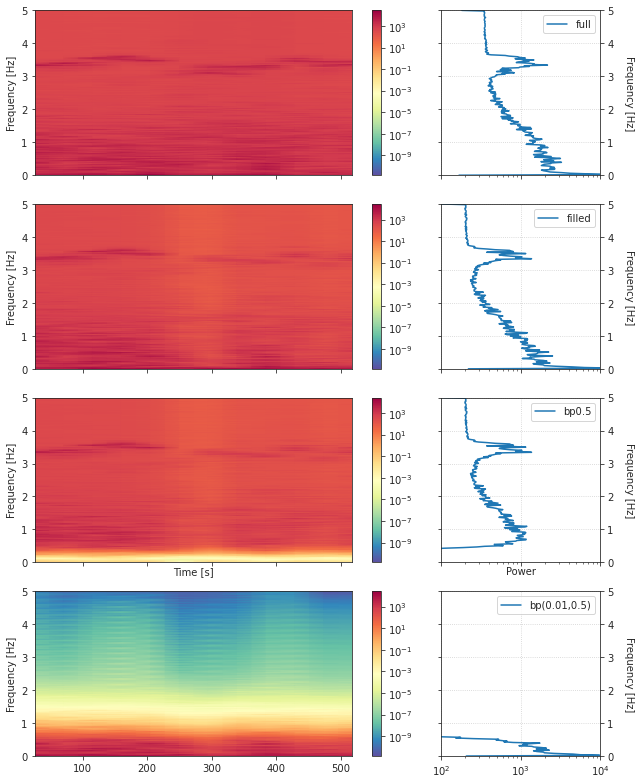

In [44]:
show_spectogram(spect_dict, (1e2, 1e4))

### Now provide custom frequencies

[<matplotlib.lines.Line2D object at 0x7f31f015d160>]

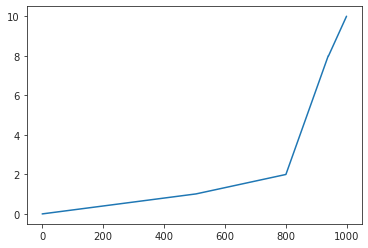

In [45]:
freqs = np.concatenate([
    np.linspace(0.005, 1, 500),
    np.linspace(1, 2, 300),
    np.linspace(2, 8, 140),
    np.linspace(8, 10, 60),
])
plt.plot(freqs)

In [46]:
kws_fill = {
    'freqs': freqs,
    'dt': 1 / 10,
}
y, yf, tmask = process_ca(mice, key, x, m_indiv, kws_fill=kws_fill, band=[0.5, (0.01, 0.5)])
segments = contig_segments(tmask)

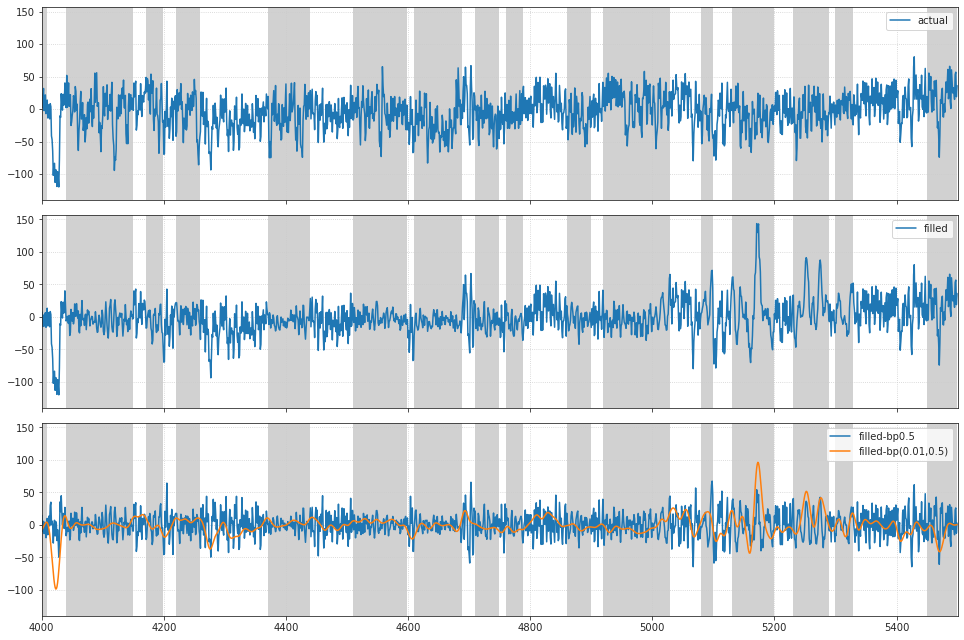

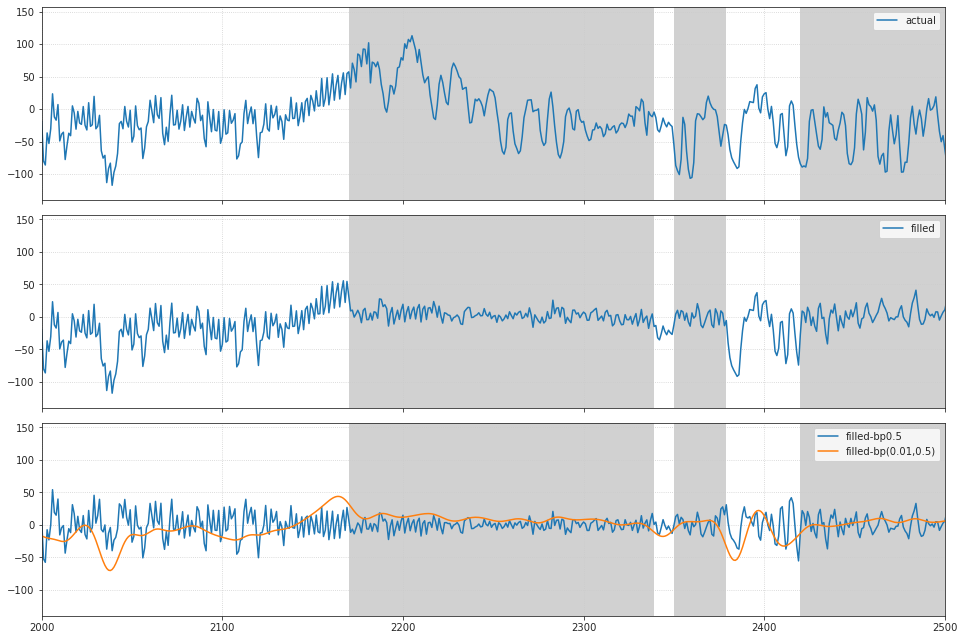

In [47]:
show_timeseries(segments, x[m_indiv], y, yf, (4000, 5500), figsize=(13.5, 9))
show_timeseries(segments, x[m_indiv], y, yf, (2000, 2500), figsize=(13.5, 9))

In [48]:
nperseg = 512
spect_dict = {
    f"bp{b}".replace(' ', ''): sp_sig.spectrogram(_y, 10, nperseg=nperseg)
    for b, _y in yf.items()
}
spect_dict = {
    'full': sp_sig.spectrogram(x[m_indiv].squeeze()[:, x.shape[-1] - len(tmask):], 10, nperseg=nperseg),
    'filled': sp_sig.spectrogram(y, 10, nperseg=nperseg),
    **spect_dict
}

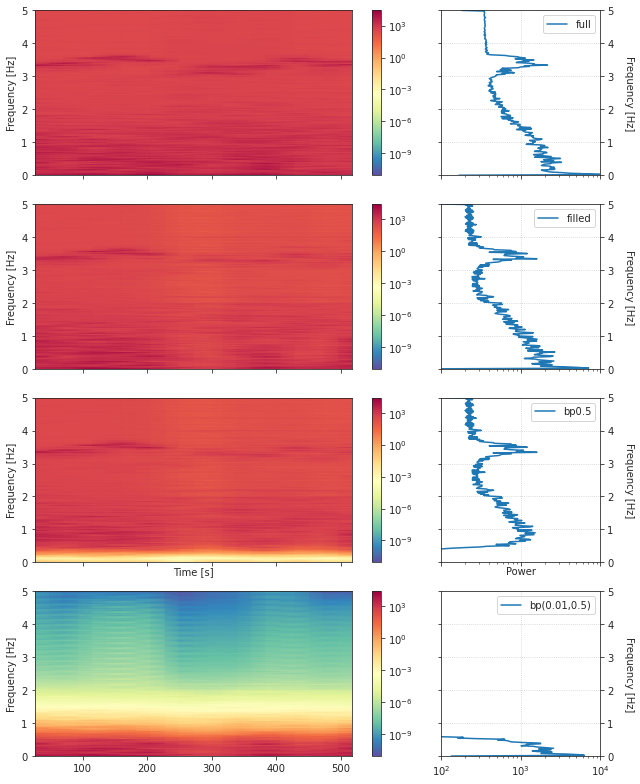

In [49]:
show_spectogram(spect_dict, (1e2, 1e4))

### Finally, linspace with Num = 2000

In [50]:
kws_fill = {
    'b': (0.005, 10),
    'logspace': False,
    'nf': 2000,
    'dt': 1 / 10,
}
y, yf, tmask = process_ca(mice, key, x, m_indiv, kws_fill=kws_fill, band=[0.5, (0.01, 0.5)])
segments = contig_segments(tmask)

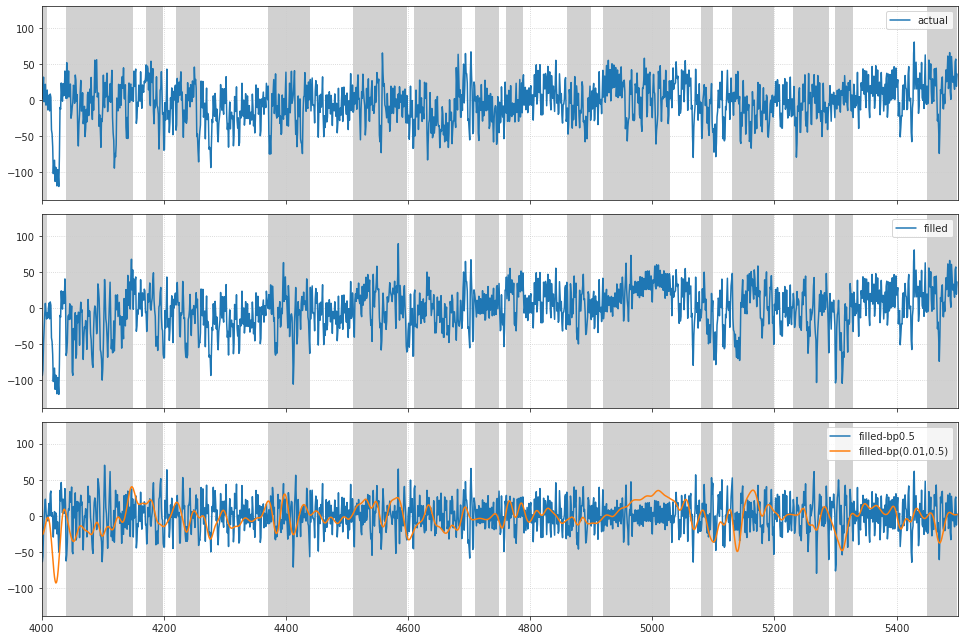

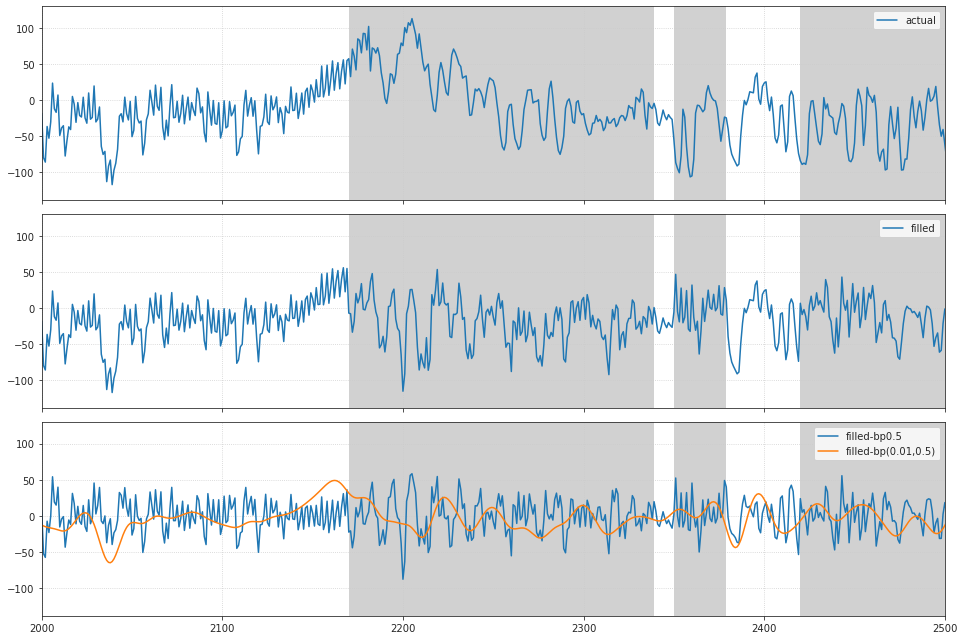

In [51]:
show_timeseries(segments, x[m_indiv], y, yf, (4000, 5500), figsize=(13.5, 9))
show_timeseries(segments, x[m_indiv], y, yf, (2000, 2500), figsize=(13.5, 9))

In [52]:
nperseg = 512
spect_dict = {
    f"bp{b}".replace(' ', ''): sp_sig.spectrogram(_y, 10, nperseg=nperseg)
    for b, _y in yf.items()
}
spect_dict = {
    'full': sp_sig.spectrogram(x[m_indiv].squeeze()[:, x.shape[-1] - len(tmask):], 10, nperseg=nperseg),
    'filled': sp_sig.spectrogram(y, 10, nperseg=nperseg),
    **spect_dict
}

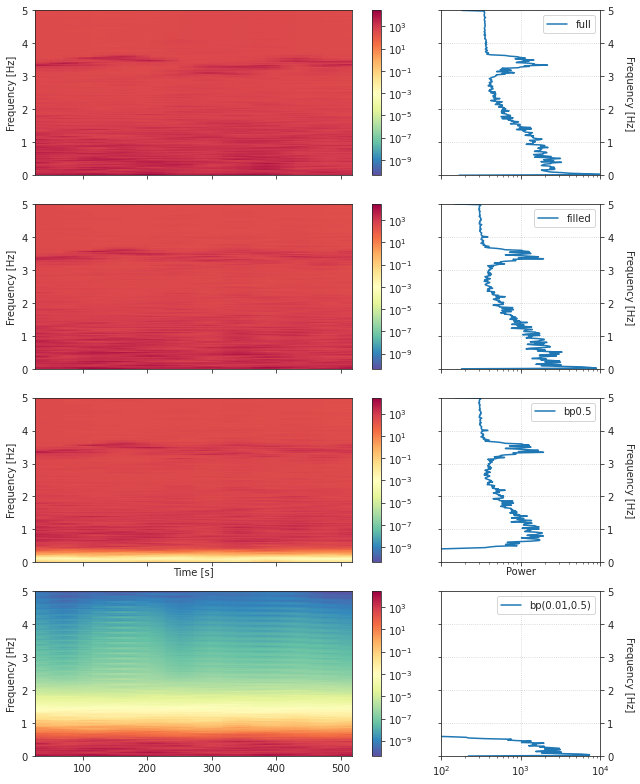

In [53]:
show_spectogram(spect_dict, (1e2, 1e4))

## Yet another run

In [54]:
_k = 'sub-SLC08_ses-2'
key = 'sub-SLC08_ses-2_run-5'
m = mice.mask3d[_k].load_ants().numpy().astype(bool)
func = mice.ca_preproc[key]

x = func.load_ants().numpy().astype(float)
x.shape

(256, 250, 1, 6000)

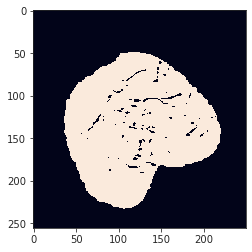

In [55]:
m_indiv = mice.mask2d[_k].load_ants()
m_indiv = m_indiv.numpy().astype(bool)
m_tsnr = tsnr_masks['ca2'].get(key)
if m_tsnr is not None:
    m_indiv = np.logical_and(m_indiv, m_tsnr)
plt.imshow(m_indiv);

### First try linspace with Num = 1000

In [56]:
kws_fill = {
    'b': (0.005, 10),
    'logspace': False,
    'nf': 1000,
    'dt': 1 / 10,
}
y, yf, tmask = process_ca(mice, key, x, m_indiv, kws_fill=kws_fill, band=[0.5, (0.01, 0.5)])
segments = contig_segments(tmask)

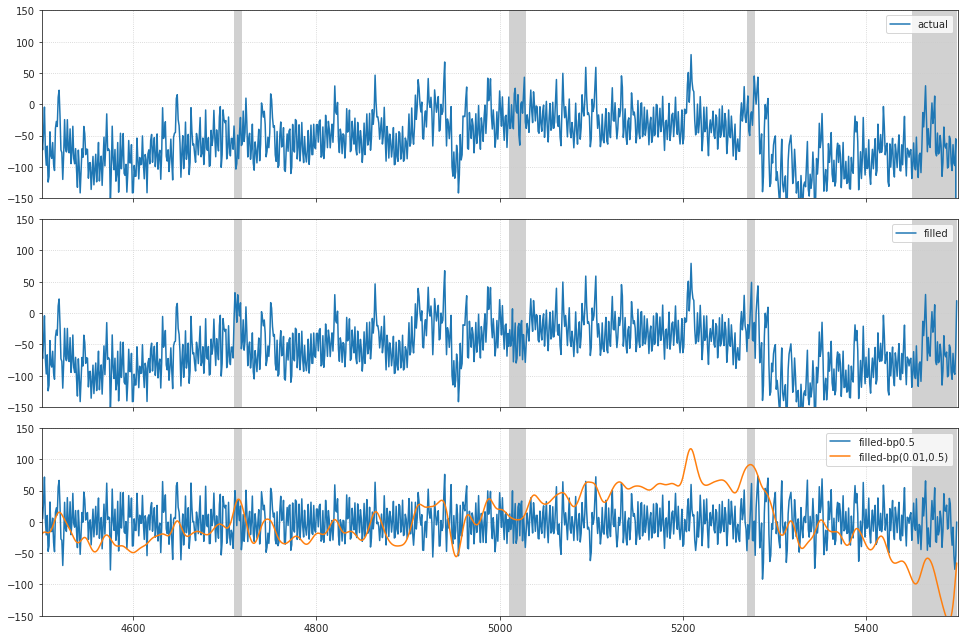

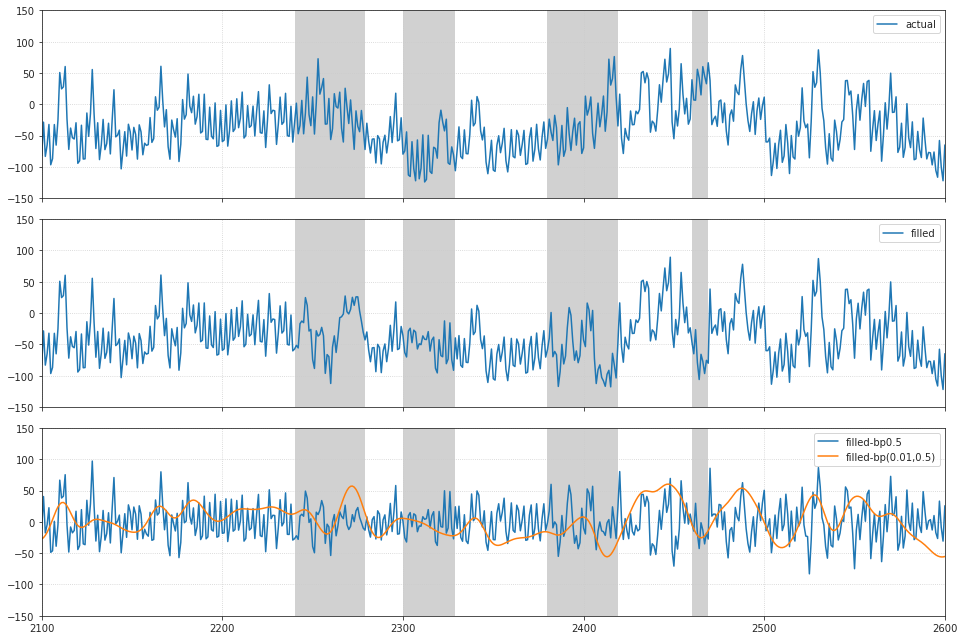

In [60]:
show_timeseries(segments, x[m_indiv], y, yf, (4500, 5500), (-150, 150), (13.5, 9))
show_timeseries(segments, x[m_indiv], y, yf, (2100, 2600), (-150, 150), (13.5, 9))

In [61]:
nperseg = 512
spect_dict = {
    f"bp{b}".replace(' ', ''): sp_sig.spectrogram(_y, 10, nperseg=nperseg)
    for b, _y in yf.items()
}
spect_dict = {
    'full': sp_sig.spectrogram(x[m_indiv].squeeze()[:, x.shape[-1] - len(tmask):], 10, nperseg=nperseg),
    'filled': sp_sig.spectrogram(y, 10, nperseg=nperseg),
    **spect_dict
}

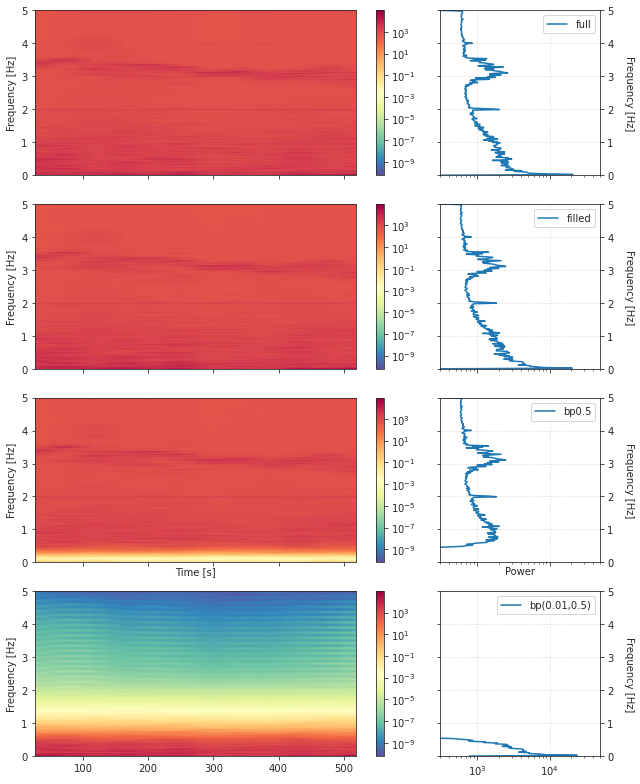

In [64]:
show_spectogram(spect_dict, (3e2, 5e4))

### What about log space Num = 1000?

In [65]:
kws_fill = {
    'b': (0.005, 10),
    'logspace': True,
    'nf': 1000,
    'dt': 1 / 10,
}
y, yf, tmask = process_ca(mice, key, x, m_indiv, kws_fill=kws_fill, band=[0.5, (0.01, 0.5)])
segments = contig_segments(tmask)

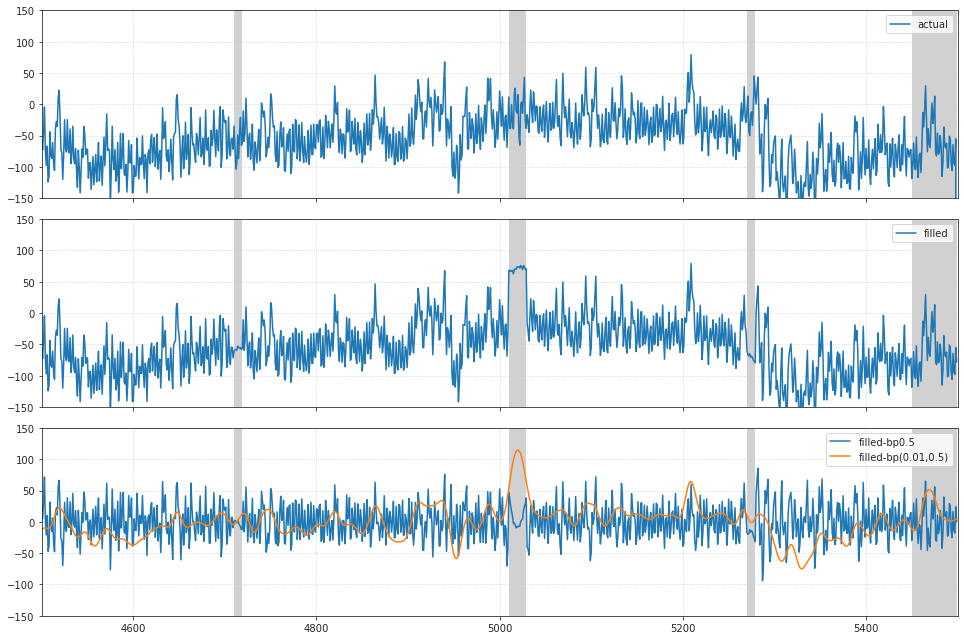

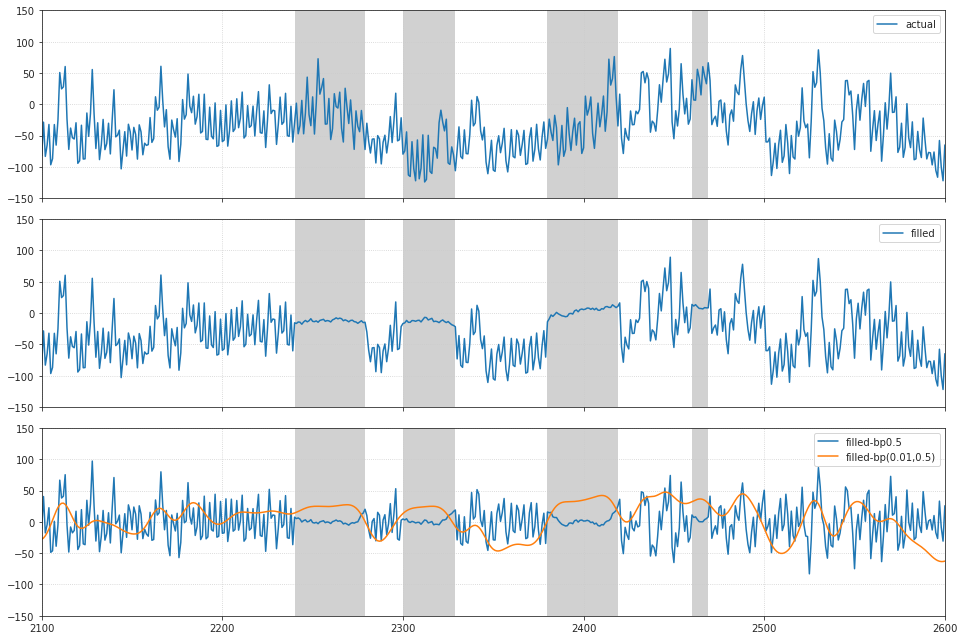

In [66]:
show_timeseries(segments, x[m_indiv], y, yf, (4500, 5500), (-150, 150), (13.5, 9))
show_timeseries(segments, x[m_indiv], y, yf, (2100, 2600), (-150, 150), (13.5, 9))

In [67]:
nperseg = 512
spect_dict = {
    f"bp{b}".replace(' ', ''): sp_sig.spectrogram(_y, 10, nperseg=nperseg)
    for b, _y in yf.items()
}
spect_dict = {
    'full': sp_sig.spectrogram(x[m_indiv].squeeze()[:, x.shape[-1] - len(tmask):], 10, nperseg=nperseg),
    'filled': sp_sig.spectrogram(y, 10, nperseg=nperseg),
    **spect_dict
}

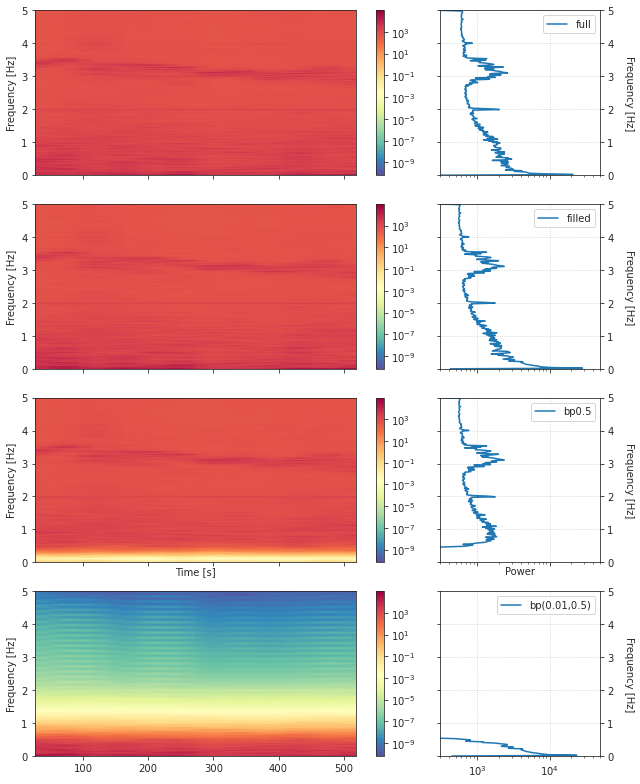

In [68]:
show_spectogram(spect_dict, (3e2, 5e4))

### Now provide custom frequencies

[<matplotlib.lines.Line2D object at 0x7f322c1400a0>]

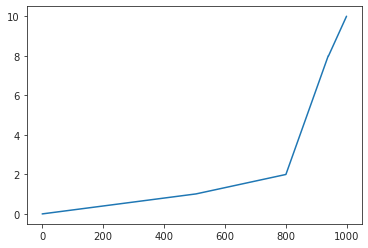

In [69]:
freqs = np.concatenate([
    np.linspace(0.005, 1, 500),
    np.linspace(1, 2, 300),
    np.linspace(2, 8, 140),
    np.linspace(8, 10, 60),
])
plt.plot(freqs)

In [70]:
kws_fill = {
    'freqs': freqs,
    'dt': 1 / 10,
}
y, yf, tmask = process_ca(mice, key, x, m_indiv, kws_fill=kws_fill, band=[0.5, (0.01, 0.5)])
segments = contig_segments(tmask)

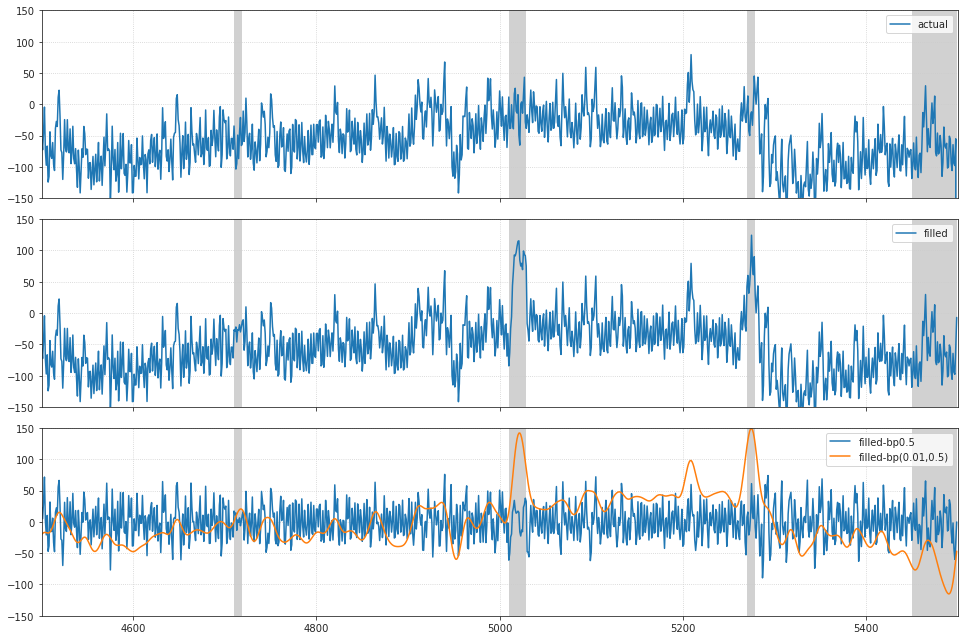

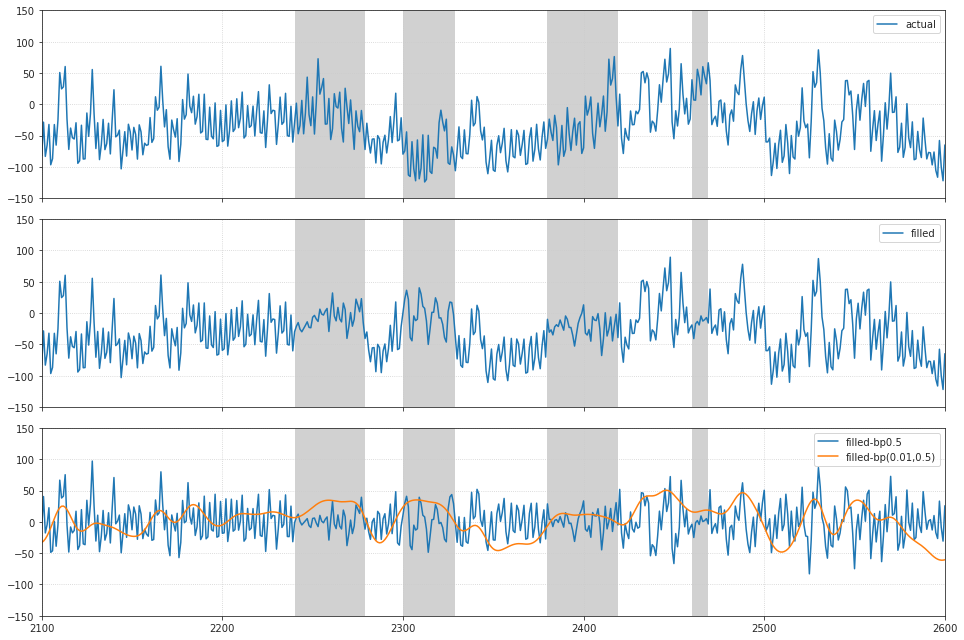

In [71]:
show_timeseries(segments, x[m_indiv], y, yf, (4500, 5500), (-150, 150), (13.5, 9))
show_timeseries(segments, x[m_indiv], y, yf, (2100, 2600), (-150, 150), (13.5, 9))

In [72]:
nperseg = 512
spect_dict = {
    f"bp{b}".replace(' ', ''): sp_sig.spectrogram(_y, 10, nperseg=nperseg)
    for b, _y in yf.items()
}
spect_dict = {
    'full': sp_sig.spectrogram(x[m_indiv].squeeze()[:, x.shape[-1] - len(tmask):], 10, nperseg=nperseg),
    'filled': sp_sig.spectrogram(y, 10, nperseg=nperseg),
    **spect_dict
}

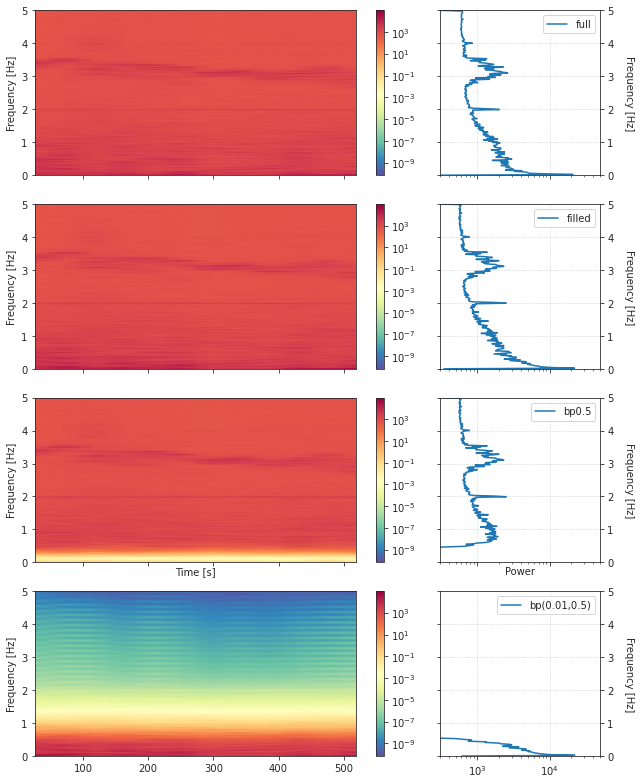

In [73]:
show_spectogram(spect_dict, (3e2, 5e4))

### Finally, linspace with Num = 2000

In [74]:
kws_fill = {
    'b': (0.005, 10),
    'logspace': False,
    'nf': 2000,
    'dt': 1 / 10,
}
y, yf, tmask = process_ca(mice, key, x, m_indiv, kws_fill=kws_fill, band=[0.5, (0.01, 0.5)])
segments = contig_segments(tmask)

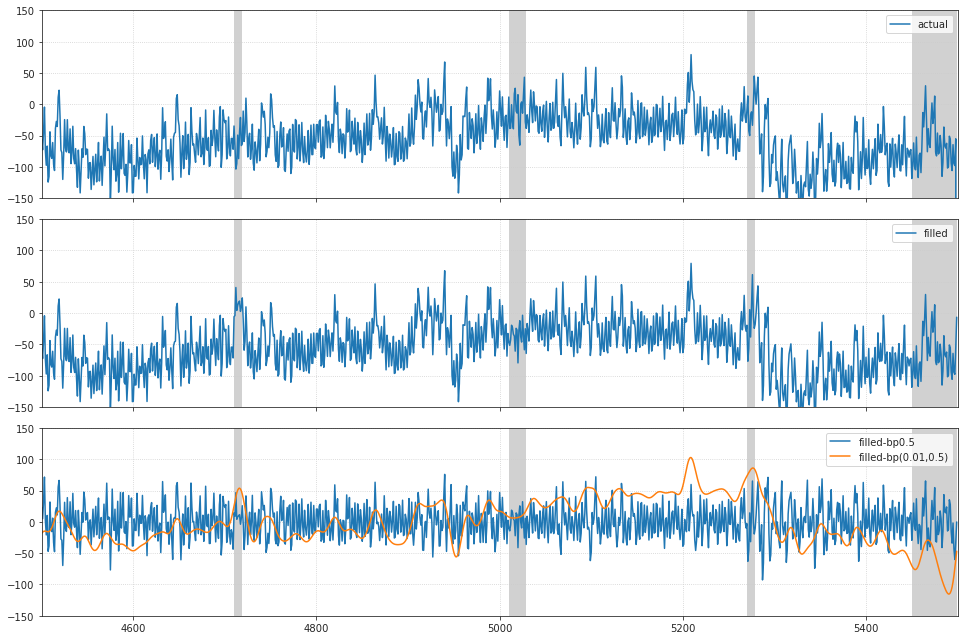

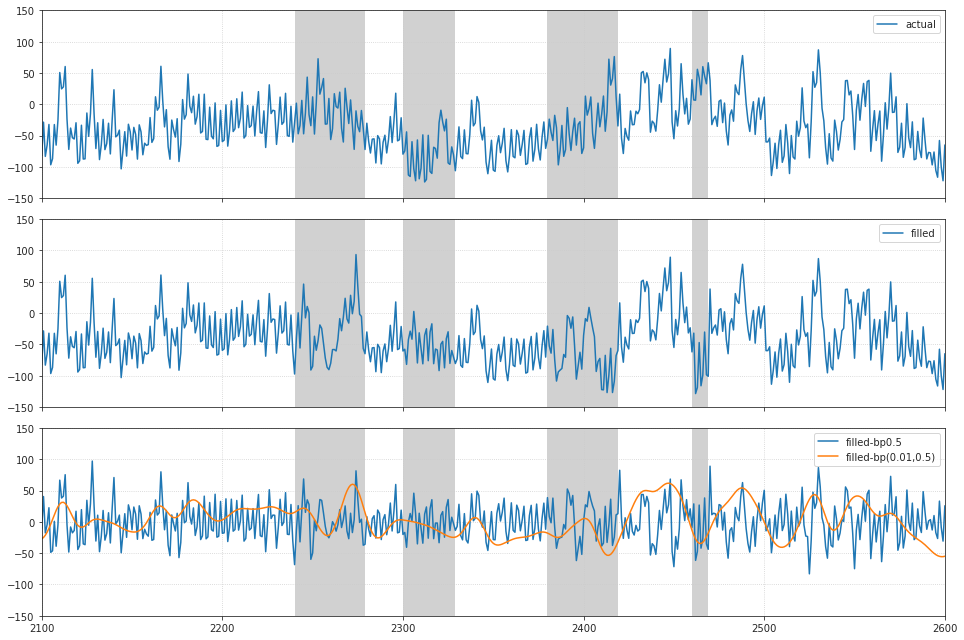

In [75]:
show_timeseries(segments, x[m_indiv], y, yf, (4500, 5500), (-150, 150), (13.5, 9))
show_timeseries(segments, x[m_indiv], y, yf, (2100, 2600), (-150, 150), (13.5, 9))

In [76]:
nperseg = 512
spect_dict = {
    f"bp{b}".replace(' ', ''): sp_sig.spectrogram(_y, 10, nperseg=nperseg)
    for b, _y in yf.items()
}
spect_dict = {
    'full': sp_sig.spectrogram(x[m_indiv].squeeze()[:, x.shape[-1] - len(tmask):], 10, nperseg=nperseg),
    'filled': sp_sig.spectrogram(y, 10, nperseg=nperseg),
    **spect_dict
}

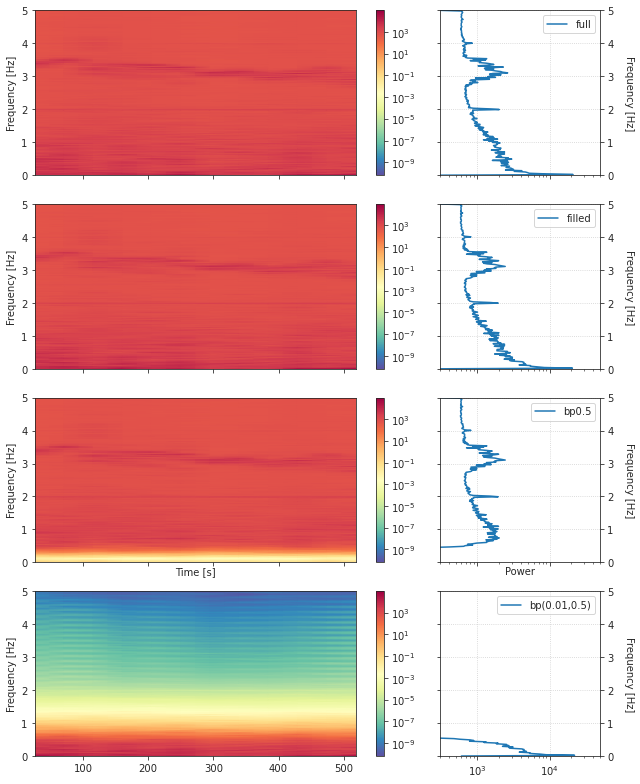

In [77]:
show_spectogram(spect_dict, (3e2, 5e4))

### Final run

In [78]:
_k = 'sub-SLC07_ses-1'
key = 'sub-SLC07_ses-1_run-6'
m = mice.mask3d[_k].load_ants().numpy().astype(bool)
func = mice.ca_preproc[key]

x = func.load_ants().numpy().astype(float)
x.shape

(256, 250, 1, 6000)

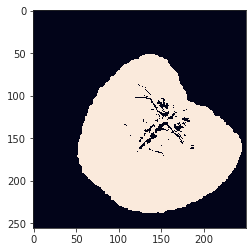

In [79]:
m_indiv = mice.mask2d[_k].load_ants()
m_indiv = m_indiv.numpy().astype(bool)
m_tsnr = tsnr_masks['ca2'].get(key)
if m_tsnr is not None:
    m_indiv = np.logical_and(m_indiv, m_tsnr)
plt.imshow(m_indiv);

### First try linspace with Num = 1000

In [80]:
kws_fill = {
    'b': (0.005, 10),
    'logspace': False,
    'nf': 1000,
    'dt': 1 / 10,
}
y, yf, tmask = process_ca(mice, key, x, m_indiv, kws_fill=kws_fill, band=[0.5, (0.01, 0.5)])
segments = contig_segments(tmask)

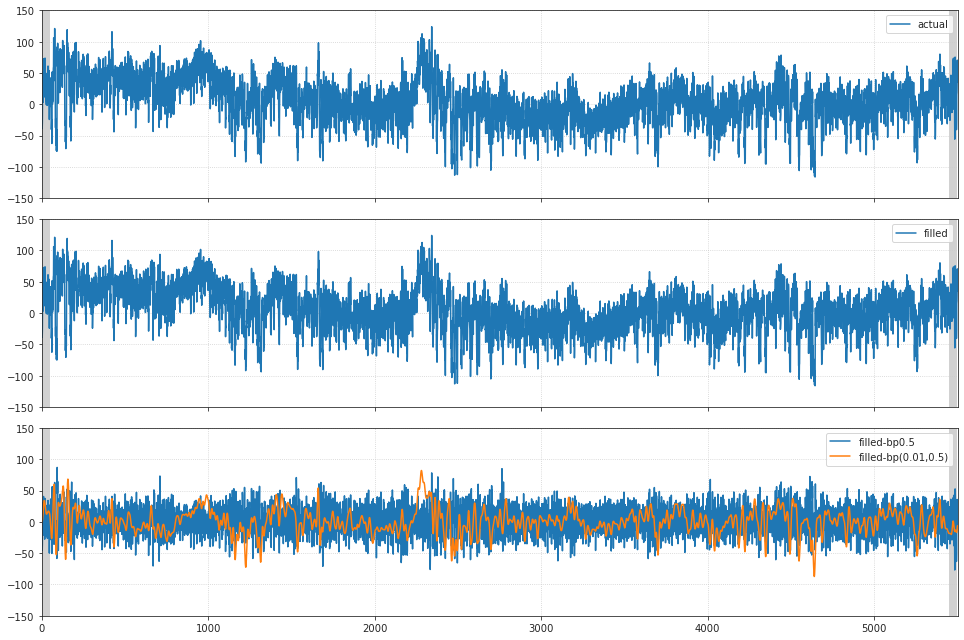

In [81]:
show_timeseries(segments, x[m_indiv], y, yf, (0, 5500), (-150, 150), (13.5, 9))

In [82]:
nperseg = 512
spect_dict = {
    f"bp{b}".replace(' ', ''): sp_sig.spectrogram(_y, 10, nperseg=nperseg)
    for b, _y in yf.items()
}
spect_dict = {
    'full': sp_sig.spectrogram(x[m_indiv].squeeze()[:, x.shape[-1] - len(tmask):], 10, nperseg=nperseg),
    'filled': sp_sig.spectrogram(y, 10, nperseg=nperseg),
    **spect_dict
}

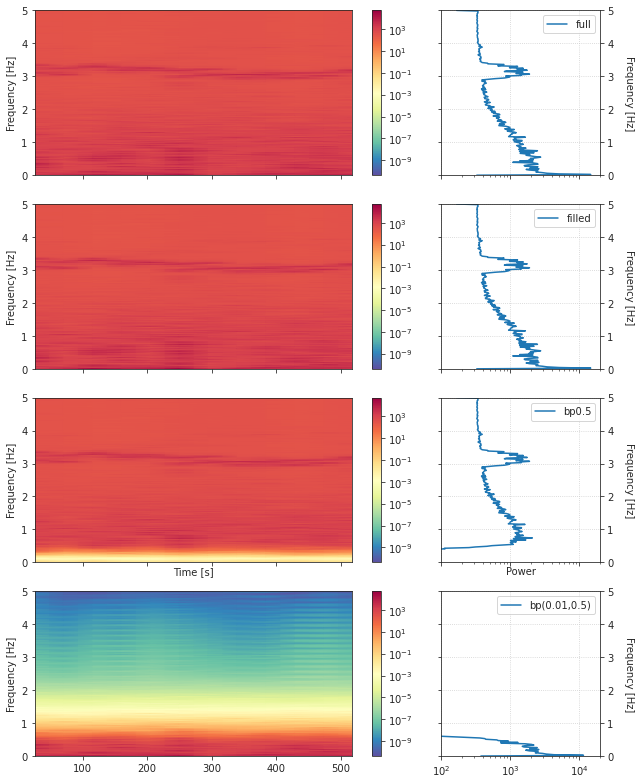

In [84]:
show_spectogram(spect_dict, (1e2, 2e4))